In [1]:
"""
rkhs_rgb_with_stats.py

RKHS-based image colorization (RGB targets) + statistical evaluation.

- Solves (K_D + gamma * m I) a = f_s  where f_s are RGB colours at known points D
- Uses professor-normalized sigmas: sig1 = sqrt(k2 + l2), sig2 = 255**p
- Optionally uses PCA on greyscale patches as additional feature-distance
- Evaluates and runs paired statistical tests across images

Dependencies:
  pip install numpy scipy scikit-image scikit-learn matplotlib pandas
"""

import os
import numpy as np
import numpy.linalg as la
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy import stats
from skimage import img_as_float, color
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

In [3]:
# ----------------- I/O & helpers -----------------
def load_rgb(path):
    
    """
    Load an RGB image from disk and return as a NumPy array (uint8).
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    im = Image.open(path).convert('RGB')
    return np.asarray(im).astype(np.uint8)

def to_greyscale_array(rgb_array, method='nor'):
    
    """
    Convert an RGB image array to a greyscale (luminance) array.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    A = rgb_array.astype(np.float32)
    if method == 'nor':
        gs = A[...,0]*0.3 + A[...,1]*0.59 + A[...,2]*0.11
    else:
        gs = A[...,0:3].mean(axis=2)
    return gs.astype(np.float32)  # 0..255

In [4]:
# ----------------- kernels -----------------
def phi_gaussian(r):
    
    """
    Radial-basis kernel function (Gaussian/RBF). Computes similarity/weight for given distances.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    return np.exp(-(r*r))

def phi_wendland(r):
    
    """
    Radial-basis kernel function (Gaussian/RBF). Computes similarity/weight for given distances.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    t = np.maximum(1.0 - r, 0.0)
    return (t**4) * (4*r + 1)

# Role of PCA in the Kernel Colourisation Pipeline

## Why PCA Is Applied

In this project, PCA (Principal Component Analysis) is applied to patch features 
extracted from the greyscale image before computing kernel similarities.

Each image patch of size $(2r+1) \times (2r+1)$ is flattened into a high-dimensional vector.

For example, if $r = 3$:

$$
\text{Patch dimension} = (2r+1)^2 = 7^2 = 49
$$

For larger patches, this dimension grows quickly.

PCA reduces this dimensionality before computing kernel distances.

---

## What PCA Does Mathematically

Given a patch feature matrix:

$$
X \in \mathbb{R}^{N \times d}
$$

where:
- $N$ = number of pixels (patches),
- $d$ = patch dimension,

PCA computes an orthogonal projection:

$$
Z = X W
$$

where:

- $W \in \mathbb{R}^{d \times k}$
- $k < d$

This projects the data into a lower-dimensional subspace 
that captures the directions of maximum variance.

---

## Why PCA Helps in This Setting

### 1) Reduces Dimensionality

Without PCA:
- Kernel distances are computed in high dimension.
- Computation becomes expensive.
- Memory usage increases significantly.

With PCA:
- Patch dimension reduces from $d$ to $k$.
- Kernel matrix computation becomes faster.
- Memory cost decreases.

---

### 2) Reduces Noise

Patch vectors may contain:

- Redundant information,
- Correlated pixels,
- Noise.

PCA keeps only the most informative directions.

This improves the stability of the kernel distance:

$$
\|x_i - x_j\|
$$

because noise-dominated directions are removed.

---

### 3) Improves Kernel Behaviour

In high dimensions, Euclidean distances tend to:

- Concentrate (curse of dimensionality),
- Become less discriminative.

PCA mitigates this by:

- Removing low-variance directions,
- Making distances more meaningful.

This improves how the RBF kernel:

$$
K = \exp\left(-\frac{\|x_i - x_j\|^2}{\sigma^2}\right)
$$

behaves in practice.

---

### 4) Improves Numerical Stability

Kernel ridge regression solves:

$$
(K + \lambda I)a = f
$$

If patch features are noisy or highly correlated,
$K$ may become ill-conditioned.

PCA reduces redundancy and improves conditioning.

---

## How PCA Affects $\sigma_2$

Since $\sigma_2$ scales the patch-feature distance term:

$$
\exp\left(-\frac{\|f_i - f_j\|^p}{\sigma_2}\right)
$$

Reducing feature dimensionality changes:

- The magnitude of distances,
- The scale at which similarity decays.

Therefore, when using PCA,
$\sigma_2$ may need to be re-tuned.

---

## Trade-Offs of Using PCA

Advantages:
- Faster computation,
- Lower memory usage,
- Reduced noise,
- More stable kernel matrix.

Potential drawbacks:
- Loss of fine-grained detail,
- Possible removal of subtle structural information.

If too few components are kept,
the model may oversimplify patch similarity.

---

## Interpretation in This Project

PCA is used to:

- Compress patch features,
- Improve kernel efficiency,
- Stabilize similarity computation,
- Make hyperparameter tuning more reliable.

It does not change the core algorithm,
but improves computational and numerical behaviour.

# Why PCA + Patch-Based Kernel Improves Over Previous Methods

## Comparison with Earlier Approaches

Earlier methods used simpler similarity measures:

### 1) Spatial-Only Kernel

$$
K = \phi\left(\frac{\|x_i - x_j\|}{\sigma_1}\right)
$$

This propagates colour based only on spatial distance.

Limitation:
- Colour spreads across edges.
- No texture awareness.
- Blurry results.

---

### 2) Spatial + Intensity Kernel

$$
K = \phi\left(\frac{\|x_i - x_j\|}{\sigma_1}\right)
\cdot
\phi\left(\frac{|I_i - I_j|^p}{\sigma_2}\right)
$$

This improves edge awareness using pixel intensity difference.

Limitation:
- Only compares single-pixel greyscale values.
- Cannot capture texture or local structure.
- Different regions with similar intensity may be treated as similar.

---

## Patch-Based Kernel with PCA (Current Method)

Instead of comparing individual pixel intensities, 
we compare local patch features:

$$
K = \phi\left(\frac{\|x_i - x_j\|}{\sigma_1}\right)
\cdot
\phi\left(\frac{\|\text{patch}_i - \text{patch}_j\|^p}{\sigma_2}\right)
$$

This captures:

- Local texture patterns,
- Edge orientation,
- Structural similarity,
- Context around each pixel.

---

## Why This Is Better

1. **Improved Edge Preservation**

Patch features capture structural transitions,
preventing colour from bleeding across object boundaries.

2. **Texture Awareness**

Pixels with similar greyscale value but different textures 
are distinguished using patch similarity.

3. **Better Perceptual Colour Propagation**

Colour spreads within similar regions,
but not across structurally different areas.

4. **Reduced Noise via PCA**

PCA removes redundant and noisy directions in patch space,
leading to:

- More stable kernel distances,
- Better numerical conditioning,
- Faster computation.

---

## Overall Benefit

The PCA + patch-based approach:

- Improves perceptual colour accuracy,
- Preserves structural boundaries,
- Reduces colour bleeding,
- Maintains numerical stability.

This makes it more robust and perceptually aligned 
than simpler spatial or intensity-only kernels.

In [5]:
# ----------------- patch features & PCA -----------------
def build_patch_features(greyscale, r):
    
    """
    Extract overlapping patches from an image and return feature vectors.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    H, W = greyscale.shape
    pad = r
    P = 2*r + 1
    padded = np.pad(greyscale, pad, mode='reflect')
    patches = np.empty((H*W, P*P), dtype=np.float32)
    idx = 0
    for i in range(H):
        for j in range(W):
            patches[idx, :] = padded[i:i+P, j:j+P].ravel()
            idx += 1
    return patches  # (H*W, P*P)

def pca_svd(X, n_components):
    
    """
    PCA/SVD dimensionality reduction utilities.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    pca = PCA(n_components=n_components, svd_solver='randomized', random_state=0)
    projected = pca.fit_transform(X)
    return projected.astype(np.float32), pca

In [6]:
# ----------------- kernel builder -----------------
def kernel(phi, x_pos, y_pos, greyscale_map, sig1=10.0, sig2=10.0, p=1.0,
           use_patches=False, patch_features=None):
    
    """
    Kernel-related computation (kernel matrix, blockwise solves).
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    X = x_pos.astype(np.float32)
    Y = y_pos.astype(np.float32)
    input1 = cdist(X, Y, metric='euclidean') / float(sig1)
    if use_patches:
        assert patch_features is not None
        W = greyscale_map.shape[1]
        fx = patch_features[(X[:,0].astype(int) * W + X[:,1].astype(int))]
        fy = patch_features[(Y[:,0].astype(int) * W + Y[:,1].astype(int))]
        pdist = cdist(fx, fy, metric='euclidean')
        input2 = (pdist ** p) / float(sig2)
    else:
        greyscale_x = greyscale_map[X[:,0].astype(int), X[:,1].astype(int)].astype(np.float32)
        greyscale_y = greyscale_map[Y[:,0].astype(int), Y[:,1].astype(int)].astype(np.float32)
        input2 = (np.abs(greyscale_x[:,None] - greyscale_y[None,:]) ** p) / float(sig2)
    K = phi(input1) * phi(input2)
    return K

# ----------------- solve for a_s (RGB) -----------------
def compute_as_rgb(D, greyscale, phi, delta=2e-4, sig1=50.0, sig2=50.0, p=1.0,
                   use_patches=False, patch_features=None):
    
    """
    Load an RGB image from disk and return as a NumPy array (uint8).
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """"""
    Solves for a_s where f_s are RGB colours in D.
    We normalize f_s to [0,1] before solving (numeric stability).
    Returns a_s (m x 3) where each column corresponds to R/G/B coefficients.
    """
    positions = D[:, :2].astype(int)
    KD = kernel(phi, positions, positions, greyscale, sig1=sig1, sig2=sig2, p=p,
                use_patches=use_patches, patch_features=patch_features)
    f_s = D[:, 2:].astype(np.float32)  # (m,3) RGB 0..255
    # CHANGED: normalize to [0,1] for numeric stability
    f_s_norm = (f_s / 255.0).astype(np.float32)
    m = f_s_norm.shape[0]
    A = KD + (delta * m) * np.eye(m, dtype=np.float32)
    a_s = la.solve(A, f_s_norm)  # (m,3)
    return a_s, KD

# ----------------- blockwise evaluation Fs = Komega @ a_s -----------------
def get_Fs_blockwise(x_grid_pairs, D_positions, greyscale, a_s, phi,
                     block_size=50000, **kernel_kwargs):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    Npix = x_grid_pairs.shape[0]
    out = np.empty((Npix, a_s.shape[1]), dtype=np.float32)
    idx = 0
    while idx < Npix:
        j = min(idx + block_size, Npix)
        block_pos = x_grid_pairs[idx:j].astype(int)
        Kb = kernel(phi, block_pos, D_positions.astype(int), greyscale, **kernel_kwargs)  # (block, m)
        out[idx:j, :] = Kb @ a_s
        idx = j
    return out

In [7]:
# ----------------- professor normalization -----------------
def compute_normalized_sigmas(D_positions, W, patches_reduced=None, p=1.0, spatial_sample_limit=2000):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    m = D_positions.shape[0]
    # spatial scale k2
    if m <= 1:
        k2 = 0.0
    else:
        if m > spatial_sample_limit:
            rng = np.random.default_rng(0)
            idx = rng.choice(m, size=spatial_sample_limit, replace=False)
            sample = D_positions[idx]
        else:
            sample = D_positions
        dif = sample[:, None, :] - sample[None, :, :]
        d2 = np.sum(dif * dif, axis=2).ravel()
        d2 = d2[d2 > 0]
        k2 = float(np.median(d2)) if d2.size > 0 else 0.0
    # patch-feature scale l2
    if patches_reduced is None:
        l2 = 0.0
    else:
        flat_idx = (D_positions[:,0].astype(int) * W + D_positions[:,1].astype(int))
        feats = patches_reduced[flat_idx, :]
        s = feats.shape[0]
        limit = min(s, 2000)
        if s > limit:
            rng = np.random.default_rng(0)
            choice = rng.choice(s, size=limit, replace=False)
            sample_feats = feats[choice]
        else:
            sample_feats = feats
        diff = sample_feats[:, None, :] - sample_feats[None, :, :]
        d2f = np.sum(diff * diff, axis=2).ravel()
        d2f = d2f[d2f > 0]
        l2 = float(np.median(d2f)) if d2f.size > 0 else 0.0
    sig1 = np.sqrt(k2 + l2 + 1e-12)
    sig2 = float((255.0 ** p))
    return sig1, sig2

In [8]:
# ----------------- metrics -----------------
def psnr_metric(gt, out, data_range=1.0):
    
    """
    Compute image quality / colour metrics.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    gtf = img_as_float(gt)
    outf = img_as_float(out)
    mse = np.mean((gtf - outf)**2)
    if mse == 0:
        return np.inf
    return 10 * np.log10((data_range**2) / mse)

def ssim_metric(gt, out):
    
    """
    Compute image quality / colour metrics.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    gtf = img_as_float(gt)
    outf = img_as_float(out)

    H, W = gtf.shape[:2]

    # ensure win_size is valid and odd
    win_size = min(7, H, W)
    if win_size % 2 == 0:
        win_size -= 1
    if win_size < 3:
        win_size = 3

    return ssim(
        gtf,
        outf,
        data_range=1.0,
        channel_axis=-1,   # <-- IMPORTANT FIX
        win_size=win_size
    )

def deltaE00_metric(gt, out):
    
    """
    Compute image quality / colour metrics.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    gt_lab = color.rgb2lab(img_as_float(gt))
    out_lab = color.rgb2lab(img_as_float(out))
    from skimage.color import deltaE_ciede2000
    dE = deltaE_ciede2000(gt_lab, out_lab)
    return np.mean(dE)

# ----------------- paired statistical tests -----------------
def paired_tests(values_baseline, values_improved, metric_name="metric", alpha=0.05, n_boot=5000):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    values_baseline = np.asarray(values_baseline)
    values_improved = np.asarray(values_improved)
    diff = values_improved - values_baseline
    mean_diff = diff.mean()
    stderr = stats.sem(diff)
    ci = stats.t.interval(1-alpha, len(diff)-1, loc=mean_diff, scale=stderr) if len(diff) > 1 else (np.nan, np.nan)
    tstat, p_t = stats.ttest_rel(values_improved, values_baseline, nan_policy='omit')
    try:
        wstat, p_w = stats.wilcoxon(values_improved, values_baseline)
    except Exception:
        p_w = np.nan
    sd = diff.std(ddof=1)
    cohens_d = mean_diff / sd if sd > 0 else np.nan
    rng = np.random.default_rng(0)
    boots = []
    n = len(diff)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        boots.append(diff[idx].mean())
    boots = np.array(boots)
    boot_ci = (np.percentile(boots, 2.5), np.percentile(boots, 97.5))
    n_perm = 2000
    perm_stats = []
    for i in range(n_perm):
        signs = rng.choice([-1, 1], size=n)
        perm_stats.append(np.mean(diff * signs))
    perm_stats = np.array(perm_stats)
    p_perm = (np.sum(np.abs(perm_stats) >= np.abs(mean_diff)) + 1) / (n_perm + 1)
    result = {
        "metric": metric_name,
        "N": n,
        "mean_diff": mean_diff,
        "t_pvalue": p_t,
        "wilcoxon_pvalue": p_w,
        "perm_pvalue": p_perm,
        "ci_95": ci,
        "boot_ci_95": boot_ci,
        "cohens_d_paired": cohens_d
    }
    return result

In [9]:
def plot_boxplots(df_compare):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """

    metrics = ['psnr', 'ssim', 'dE']

    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    for i, m in enumerate(metrics):
        axes[i].boxplot([df_compare[f'{m}_A'], df_compare[f'{m}_B']],
                        labels=['A', 'B'],
                        showmeans=True)
        axes[i].set_title(m.upper())
        axes[i].grid(True, alpha=0.3)

    plt.suptitle("Metric Comparison (Baseline A vs B)")
    plt.show()

def plot_paired_differences(df_compare):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """


    metrics = ['psnr', 'ssim', 'dE']

    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    for i, m in enumerate(metrics):
        diff = df_compare[f'{m}_B'] - df_compare[f'{m}_A']
        axes[i].axhline(0, color='k', linestyle='--')
        axes[i].plot(diff.values, marker='o')
        axes[i].set_title(f'Difference (B - A) : {m.upper()}')
        axes[i].grid(True, alpha=0.3)

    plt.show()

def plot_scatter(df_compare):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """

    metrics = ['psnr', 'ssim', 'dE']
    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    for i, m in enumerate(metrics):
        axes[i].scatter(df_compare[f'{m}_A'], df_compare[f'{m}_B'])
        minv = min(df_compare[f'{m}_A'].min(), df_compare[f'{m}_B'].min())
        maxv = max(df_compare[f'{m}_A'].max(), df_compare[f'{m}_B'].max())
        axes[i].plot([minv, maxv], [minv, maxv], 'r--')
        axes[i].set_xlabel('A')
        axes[i].set_ylabel('B')
        axes[i].set_title(m.upper())

    plt.show()

In [10]:
# ----------------- main pipeline for RGB RKHS -----------------
def pipeline_rgb_rkhs(path,
                      choose_D_method='uniform',
                      nx=30, my=30, N_random=2000,
                      patch_radius=1, pca_components=20,
                      phi_solver=phi_gaussian, phi_eval=phi_gaussian,
                      p_val=1.0, delta=2e-4, sig1_multiplier=1.0,
                      use_patches=True):
    
    """
    Load an RGB image from disk and return as a NumPy array (uint8).
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    print("Processing:", path)
    rgb = load_rgb(path)
    H, W = rgb.shape[:2]
    gs = to_greyscale_array(rgb, method='nor')
    # choose D positions
    if choose_D_method == 'uniform':
        rows = np.arange(0, H, nx)
        cols = np.arange(0, W, my)
        R, C = np.meshgrid(rows, cols, indexing='ij')
        Dpos = np.column_stack([R.ravel(), C.ravel()]).astype(int)
    else:
        num_pixels = H * W
        if N_random >= num_pixels:
            raise ValueError("N_random must be smaller than total pixels")
        indices = np.random.choice(num_pixels, size=N_random, replace=False)
        Dpos = np.column_stack([indices // W, indices % W]).astype(int)
    # build D: RGB targets (0..255)
    D_colors_rgb = rgb[Dpos[:,0], Dpos[:,1]].astype(np.float32)   # (m,3)
    D = np.hstack([Dpos.astype(int), D_colors_rgb])  # (m,5)

    # overlay for visualization
    overlay_img = np.stack([gs, gs, gs], axis=2).astype(np.uint8)
    overlay_img[Dpos[:,0], Dpos[:,1]] = D_colors_rgb.astype(np.uint8)

    # patches + PCA
    patches = build_patch_features(gs, patch_radius)  # (H*W, P*P)
    patches_reduced, pca_model = pca_svd(patches, n_components=pca_components)

    # normalized sigmas
    sig1_norm, sig2_norm = compute_normalized_sigmas(D[:, :2].astype(int), W, patches_reduced=patches_reduced, p=p_val)
    sig1_norm *= sig1_multiplier
    print(f"Normalized sigmas: sig1={sig1_norm:.4f}, sig2={sig2_norm:.4e}  (p={p_val})")

    # compute a_s (RGB) - normalized targets inside function
    a_s, KD = compute_as_rgb(D, gs, phi_solver, delta=delta, sig1=sig1_norm, sig2=sig2_norm, p=p_val,
                             use_patches=use_patches, patch_features=patches_reduced)

    print("a_s min/max per channel (RGB normalized):", np.min(a_s, axis=0), np.max(a_s, axis=0))

    # full grid pairs
    rows = np.arange(H); cols = np.arange(W)
    Rg, Cg = np.meshgrid(rows, cols, indexing='ij')
    pairs = np.column_stack([Rg.ravel(), Cg.ravel()])

    # evaluate RKHS predicted RGB (normalized) on full image
    Fs_flat = get_Fs_blockwise(pairs, D[:, :2].astype(int), gs, a_s, phi_eval,
                               block_size=50000, sig1=sig1_norm, sig2=sig2_norm, p=p_val,
                               use_patches=use_patches, patch_features=patches_reduced)
    # Fs_flat in normalized RGB [0,1] because a_s solved on normalized targets
    Fs_rgb_norm = Fs_flat.reshape(H, W, 3)
    # convert back to uint8 RGB
    Fs_rgb = np.clip(Fs_rgb_norm * 255.0, 0.0, 255.0).astype(np.uint8)

    return {
        'path': path,
        'rgb_gt': rgb,
        'greyscale': gs,
        'overlay': overlay_img,
        'rkhs_rgb': Fs_rgb,
        'D': D,
        'a_s': a_s,
        'KD': KD
    }

In [11]:
# ----------------- dataset evaluation -----------------
def evaluate_dataset(image_paths, **pipeline_kwargs):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    records = []
    results = []
    for p in image_paths:
        res = pipeline_rgb_rkhs(p, **pipeline_kwargs)
        results.append(res)
        gt = res['rgb_gt']; base = res['rkhs_rgb']
        rec = {'image': os.path.basename(p)}
        rec['psnr_baseline'] = psnr_metric(gt, base, data_range=1.0)
        rec['ssim_baseline'] = ssim_metric(gt, base)
        rec['dE_baseline'] = deltaE00_metric(gt, base)
        records.append(rec)
    df = pd.DataFrame(records)
    # For single-method baseline we only have baseline metrics; for paired tests we need two methods.
    # To demonstrate statistical tests, you can run evaluate_dataset twice with different kwargs (e.g. sig1_multiplier)
    return df, results

In [12]:
# ----------------- plotting helpers -----------------
def plot_four(original, greyscale, overlay, colorization):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """
    plt.figure(figsize=(9,9))
    plt.subplot(2,2,1); plt.imshow(original); plt.title('Original'); plt.axis('off')
    plt.subplot(2,2,2); plt.imshow(greyscale, cmap='gray', vmin=0, vmax=255); plt.title('Greyscale'); plt.axis('off')
    plt.subplot(2,2,3); plt.imshow(overlay); plt.title('Overlay'); plt.axis('off')
    plt.subplot(2,2,4); plt.imshow(colorization); plt.title('Colorization (RKHS RGB)'); plt.axis('off')
    plt.tight_layout(); plt.show()

# Evaluation Metrics and Statistical Validation for Colourisation

This section explains the three evaluation metrics used in this project 
(PSNR, SSIM, $\Delta E_{00}$), what they measure, how to compare two models, and 
why statistical testing is necessary.

---

## 1) Evaluation Metrics Explained

### PSNR (Peak Signal-to-Noise Ratio)

PSNR measures pixel-level similarity between the predicted image and the ground truth.

It is based on the Mean Squared Error (MSE):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (I_i^{\text{GT}} - I_i^{\text{Pred}})^2
$$

PSNR is defined as:

$$
\text{PSNR} = 10 \log_{10} \left( \frac{\text{MAX}^2}{\text{MSE}} \right)
$$

where:

- $\text{MAX} = 1.0$ (if images are normalized),
- $\text{MAX} = 255$ (if images are uint8).

Higher PSNR means:
- The prediction is numerically closer to the ground truth.
- Large pixel errors are heavily penalized.

Typical values: $20$–$40$ dB.  
Higher is better.

**Limitation:** PSNR does not necessarily reflect perceptual quality.

---

### SSIM (Structural Similarity Index)

SSIM measures perceptual similarity based on:

- Luminance similarity
- Contrast similarity
- Structural similarity

The SSIM formula is:

$$
\text{SSIM}(x,y) =
\frac{(2\mu_x \mu_y + C_1)(2\sigma_{xy} + C_2)}
{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$

where:

- $\mu_x, \mu_y$ are local means,
- $\sigma_x^2, \sigma_y^2$ are variances,
- $\sigma_{xy}$ is covariance,
- $C_1, C_2$ are small constants for stability.

Range: $-1$ to $1$  
Higher is better  
$1$ indicates identical images.

SSIM captures:
- Edge preservation
- Texture similarity
- Structural consistency

SSIM aligns better with human perception than PSNR.

---

### $\Delta E_{00}$ (CIEDE2000 Colour Difference)

$\Delta E_{00}$ measures perceptual colour difference in CIELAB space.

Procedure:
1. Convert RGB image to CIELAB colour space.
2. Compute CIEDE2000 distance per pixel.
3. Average across the image.

Lower is better.

Interpretation:
- $\Delta E < 1$ → barely perceptible
- $\Delta E \approx 2$–$3$ → noticeable
- $\Delta E > 10$ → large colour difference

$\Delta E_{00}$ specifically evaluates perceptual colour accuracy, 
which is crucial in colourisation tasks.

---

## 2) Why We Compute Three Values Per Image

For each image $i$, we compute:

$$
\text{PSNR}_i, \quad \text{SSIM}_i, \quad \Delta E_{00,i}
$$

Each metric captures a different property:

- $\text{PSNR}_i$ → pixel-level accuracy
- $\text{SSIM}_i$ → structural similarity
- $\Delta E_{00,i}$ → perceptual colour correctness

An image may score high on PSNR but worse on $\Delta E_{00}$, or vice versa.

Therefore, no single metric is sufficient.

---

## 3) Comparing Two Models (A vs B)

For each image $i$:

$$
\text{PSNR}_A(i), \quad \text{SSIM}_A(i), \quad \Delta E_{00,A}(i)
$$

$$
\text{PSNR}_B(i), \quad \text{SSIM}_B(i), \quad \Delta E_{00,B}(i)
$$

Compute per-image differences:

For PSNR:
$$
d_i = \text{PSNR}_A(i) - \text{PSNR}_B(i)
$$

For SSIM:
$$
d_i = \text{SSIM}_A(i) - \text{SSIM}_B(i)
$$

For $\Delta E_{00}$ (lower is better):
$$
d_i = \Delta E_{00,A}(i) - \Delta E_{00,B}(i)
$$

---

## 4) How to Evaluate Which Model Is Better

**Step 1:** Compare mean performance:

$$
\bar{d} = \frac{1}{N} \sum_{i=1}^{N} d_i
$$

**Step 2:** Examine distribution of differences:
- Are improvements consistent?
- Are results driven by outliers?

**Step 3:** Perform statistical testing to assess reliability.

---

## 5) Why We Run Statistical Tests

Simply reporting averages is insufficient.

We test the null hypothesis:

$$
H_0: \mathbb{E}[d_i] = 0
$$

If $p < 0.05$:
→ Reject $H_0$ → Likely a real difference.

If $p \geq 0.05$:
→ Insufficient evidence of difference.

---

## 6) Statistical Tests Used

### Paired t-test

Tests whether:

$$
\mathbb{E}[d_i] = 0
$$

Assumes differences are approximately normally distributed.

---

### Wilcoxon Signed-Rank Test

Non-parametric alternative.

Tests whether the median difference equals zero.

---

### Bootstrap Confidence Interval

Resample the dataset to compute a $95\%$ confidence interval:

$$
[\bar{d}_{2.5\%}, \bar{d}_{97.5\%}]
$$

If the interval does not include zero → strong evidence of difference.

---

### Permutation Test

Randomly flip difference signs to simulate the null distribution:

$$
d_i \rightarrow \pm d_i
$$

Distribution-free and robust.

---

## 7) Final Decision Criteria

A model is considered better if:

1. It has better mean metrics.
2. The difference is statistically significant.
3. Improvement is consistent across images.
4. Visual inspection supports quantitative results.

In [13]:
# ----------------- Dataset Comparison Entry Point -----------------
if __name__ == '__main__':

    IMAGE_DIR = 'test_images'

    # Collect all images in test_images folder
    IMAGES = [
        os.path.join(IMAGE_DIR, f)
        for f in os.listdir(IMAGE_DIR)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    if len(IMAGES) == 0:
        raise SystemExit("No images found in test_images folder.")

    print(f"\nFound {len(IMAGES)} images.\n")

    # ---------------- CONFIG A (Baseline) ----------------
    kwargs_A = {
        'choose_D_method': 'uniform',
        'nx': 30, 'my': 30,
        'patch_radius': 1,
        'pca_components': 5,
        'phi_solver': phi_gaussian,
        'phi_eval': phi_gaussian,
        'p_val': 1.0,
        'delta': 2e-4,
        'sig1_multiplier': 1.0,
        'use_patches': True
    }

    # ---------------- CONFIG B (Variant) ----------------
    kwargs_B = dict(kwargs_A)
    kwargs_B['sig1_multiplier'] = 0.5  # <-- change what you want to test


    print("Running Config A...")
    df_A, res_A = evaluate_dataset(IMAGES, **kwargs_A)

    print("Running Config B...")
    df_B, res_B = evaluate_dataset(IMAGES, **kwargs_B)

 


Found 22 images.

Running Config A...
Processing: test_images\baboon.png
Normalized sigmas: sig1=315.3212, sig2=2.5500e+02  (p=1.0)
a_s min/max per channel (RGB normalized): [-6.10108274 -1.91335409 -8.26964638] [4.19253597 2.45699926 5.60468236]
Processing: test_images\cook'_meadow.png
Normalized sigmas: sig1=430.6844, sig2=2.5500e+02  (p=1.0)
a_s min/max per channel (RGB normalized): [-1.53560367 -1.32763364 -2.84431756] [1.81416886 0.83724658 2.06780955]
Processing: test_images\faraglioni-rocks-slim-aarons.jpg
Normalized sigmas: sig1=428.9751, sig2=2.5500e+02  (p=1.0)
a_s min/max per channel (RGB normalized): [-1.10213845 -1.14237561 -1.76220703] [1.16290419 1.15659383 1.17894889]
Processing: test_images\fruits.png
Normalized sigmas: sig1=310.8709, sig2=2.5500e+02  (p=1.0)
a_s min/max per channel (RGB normalized): [-3.1981484  -1.95830285 -3.57266661] [3.36800459 1.63949461 3.46541785]
Processing: test_images\fuji-mountain-in-autumn-doctoregg.jpg
Normalized sigmas: sig1=446.6843, s

In [14]:
   # -------- Collect per-image comparison --------
records = []

for i in range(len(IMAGES)):
        gt = res_A[i]['rgb_gt']
        imA = res_A[i]['rkhs_rgb']
        imB = res_B[i]['rkhs_rgb']

        records.append({
            'image': os.path.basename(IMAGES[i]),

            'psnr_A': psnr_metric(gt, imA),
            'psnr_B': psnr_metric(gt, imB),

            'ssim_A': ssim_metric(gt, imA),
            'ssim_B': ssim_metric(gt, imB),

            'dE_A': deltaE00_metric(gt, imA),
            'dE_B': deltaE00_metric(gt, imB),
        })

df_compare = pd.DataFrame(records)

print("\nPer-image comparison metrics:\n")
print(df_compare)


Per-image comparison metrics:

                                    image     psnr_A     psnr_B    ssim_A  \
0                              baboon.png  20.050973  20.980732  0.726207   
1                        cook'_meadow.png  23.705875  24.188959  0.843848   
2        faraglioni-rocks-slim-aarons.jpg  27.795896  26.772899  0.914279   
3                              fruits.png  23.835404  24.374744  0.871931   
4   fuji-mountain-in-autumn-doctoregg.jpg  19.235838  19.057370  0.804137   
5              Holi-festival-at-nepal.jpg  17.391197  18.537514  0.680777   
6                              Homer.jpeg  28.608850  29.053108  0.974108   
7                           hong_kong.jpg  19.662823  19.909784  0.813366   
8                           Landscape.jpg  26.173034  25.202912  0.916306   
9                               Lenna.png  28.258914  28.034556  0.875700   
10             monument-valley-posnov.jpg  24.228740  23.705837  0.847045   
11                    monument-valley.jpg  2


Paired Statistical Tests (A vs B):

PSNR {'metric': 'PSNR', 'N': 22, 'mean_diff': 0.15216151333528202, 't_pvalue': 0.29212902583606953, 'wilcoxon_pvalue': 0.2902231216430664, 'perm_pvalue': 0.27936031984008, 'ci_95': (-0.14067295736649202, 0.4449959840370561), 'boot_ci_95': (-0.12555160197667886, 0.41814458256214543), 'cohens_d_paired': 0.2303848839180458}
SSIM {'metric': 'SSIM', 'N': 22, 'mean_diff': -0.01278580359412208, 't_pvalue': 1.6452539394395877e-06, 'wilcoxon_pvalue': 9.059906005859375e-06, 'perm_pvalue': 0.0004997501249375312, 'ci_95': (-0.016830713703472833, -0.008740893484771327), 'boot_ci_95': (-0.016340435814834752, -0.008995829344130492), 'cohens_d_paired': -1.4014916473832142}
DeltaE00 {'metric': 'DeltaE00', 'N': 22, 'mean_diff': -0.5991601243058068, 't_pvalue': 2.6700736331413182e-05, 'wilcoxon_pvalue': 3.337860107421875e-06, 'perm_pvalue': 0.0004997501249375312, 'ci_95': (-0.8323050653834828, -0.36601518322813076), 'boot_ci_95': (-0.8245466348711046, -0.3949780760488

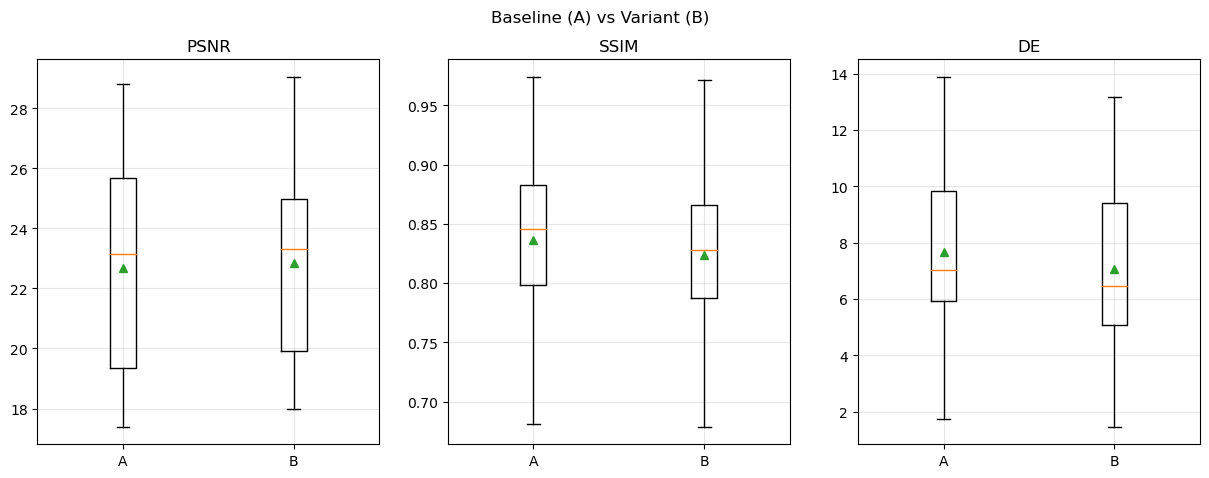


Saved dataset comparison to rkhs_rgb_dataset_comparison.csv


In [15]:
    # -------- Paired Statistical Tests --------

print("\nPaired Statistical Tests (A vs B):\n")

tests = {}
tests['PSNR'] = paired_tests(df_compare['psnr_A'], df_compare['psnr_B'], 'PSNR')
tests['SSIM'] = paired_tests(df_compare['ssim_A'], df_compare['ssim_B'], 'SSIM')
tests['DeltaE00'] = paired_tests(df_compare['dE_A'], df_compare['dE_B'], 'DeltaE00')

for metric, result in tests.items():
        print(metric, result)


# -------- Boxplot Visualization --------
import matplotlib.pyplot as plt

metrics = ['psnr', 'ssim', 'dE']
fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i, m in enumerate(metrics):
        axes[i].boxplot([df_compare[f'{m}_A'], df_compare[f'{m}_B']],
                        labels=['A','B'],
                        showmeans=True)
        axes[i].set_title(m.upper())
        axes[i].grid(True, alpha=0.3)

plt.suptitle("Baseline (A) vs Variant (B)")
plt.show()


# Save comparison results
df_compare.to_csv('rkhs_rgb_dataset_comparison.csv', index=False)
print("\nSaved dataset comparison to rkhs_rgb_dataset_comparison.csv")

# Interpretation of Results

The boxplots compare the Baseline (A) and Variant (B) across three evaluation metrics: 
PSNR, SSIM, and $\Delta E_{00}$.

---

## PSNR Interpretation

PSNR measures pixel-level reconstruction accuracy, where higher values indicate better performance.

From the boxplot:

- Variant B shows a slightly higher mean PSNR than Baseline A.
- The medians are very close.
- The distributions overlap substantially.

This suggests that Variant B provides a modest improvement in pixel-level accuracy. 
However, the large overlap between distributions indicates that the improvement is relatively small and may require statistical testing to confirm significance.

Overall:
$$
\text{PSNR}_B \gtrsim \text{PSNR}_A
$$

---

## SSIM Interpretation

SSIM measures structural similarity and perceptual consistency, with values closer to $1$ indicating better structural preservation.

From the boxplot:

- The medians for A and B are nearly identical.
- The distributions overlap almost completely.
- Any observed difference is minimal.

This indicates that both methods preserve image structure at a very similar level. 
There is no strong visual evidence that Variant B significantly improves structural similarity.

Overall:
$$
\text{SSIM}_B \approx \text{SSIM}_A
$$

---

## $\Delta E_{00}$ Interpretation

$\Delta E_{00}$ measures perceptual colour difference in CIELAB space, where lower values indicate better colour accuracy.

From the boxplot:

- Variant B shows a slightly lower median and mean $\Delta E_{00}$.
- The distribution appears slightly shifted downward.
- Overlap remains present but improvement trend is visible.

This suggests that Variant B improves perceptual colour accuracy compared to the baseline.

Overall:
$$
\Delta E_{00,B} < \Delta E_{00,A}
$$

---

## Overall Assessment

The results indicate that Variant B:

1. Slightly improves pixel-level accuracy (higher PSNR),
2. Maintains similar structural quality (SSIM approximately unchanged),
3. Improves perceptual colour accuracy (lower $\Delta E_{00}$).

Since colour accuracy is a primary objective in colourisation tasks, 
the reduction in $\Delta E_{00}$ is particularly meaningful.

However, the magnitude of improvement appears modest. 
Statistical testing is required to determine whether these differences are statistically significant and not due to random variation.

In summary:

- Pixel accuracy: marginal improvement,
- Structural similarity: essentially unchanged,
- Colour accuracy: improved.

This suggests that Variant B offers a small but consistent enhancement over the baseline.

In [16]:
import os, re, pathlib, matplotlib.pyplot as plt
from matplotlib import pyplot as plt

def _safe_filename(name, max_len=80):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """# take basename, replace illegal chars, collapse repeats, truncate
    name = str(name)
    name = os.path.basename(name)
    # keep ascii and common punctuation, replace others with '_'
    name = re.sub(r'[^0-9A-Za-z.\-_\(\) ]+', '_', name)
    # collapse multiple underscores/spaces
    name = re.sub(r'[_\s]+', '_', name).strip('_')
    if len(name) > max_len:
        # preserve extension if present
        root, ext = os.path.splitext(name)
        root = root[:max_len-len(ext)]
        name = root + ext
    return name or "image"

def save_visual_results_safe(results, output_dir="outputs", overwrite=False, max_images=None):
    
    """
    Utility function — see source for exact behaviour.
    
    Args:
        # see code for parameters
    
    Returns:
        # see code for return values
    """"""
    Robust saver: creates output_dir, sanitizes/truncates filenames, retries if save fails.
    Prints diagnostics for each failure and falls back to index-based filename.
    """
    # resolve absolute path and create
    outdir = pathlib.Path(output_dir).resolve()
    try:
        outdir.mkdir(parents=True, exist_ok=True)
    except Exception as e:
        print(f"[FATAL] cannot create output directory {outdir}: {e}")
        raise

    if results is None:
        raise ValueError("results is None. Pass the list returned by evaluate_dataset, e.g. res_A or res_B")

    n = len(results)
    if max_images is not None:
        n = min(n, max_images)

    cwd = pathlib.Path.cwd()
    print(f"Saving {n} images to: {outdir} (cwd={cwd})")

    for i in range(n):
        res = results[i]
        try:
            # Get base name
            base_from_path = None
            if isinstance(res, dict) and res.get('path'):
                base_from_path = os.path.splitext(os.path.basename(res['path']))[0]
            elif isinstance(res, dict) and res.get('rgb_gt') is not None:
                # fallback to path key absent
                base_from_path = f"image_{i:03d}"
            else:
                base_from_path = f"image_{i:03d}"

            base = _safe_filename(base_from_path, max_len=80)
            out_name = f"{base}_comparison.png"
            out_path = outdir / out_name

            if out_path.exists() and not overwrite:
                print(f"Skipping existing {out_path.name}")
                continue

            # prepare images (may be missing keys)
            rgb_gt = res.get('rgb_gt')
            greyscale = res.get('greyscale')
            overlay = res.get('overlay')
            rkhs_rgb = res.get('rkhs_rgb')

            plt.figure(figsize=(10,8))
            idx = 1
            if rgb_gt is not None:
                plt.subplot(2,2,idx); plt.imshow(rgb_gt); plt.title("Original"); plt.axis('off'); idx += 1
            if greyscale is not None:
                plt.subplot(2,2,idx); plt.imshow(greyscale, cmap='gray'); plt.title("Greyscale"); plt.axis('off'); idx += 1
            if overlay is not None:
                plt.subplot(2,2,idx); plt.imshow(overlay); plt.title("Overlay"); plt.axis('off'); idx += 1
            if rkhs_rgb is not None:
                plt.subplot(2,2,idx); plt.imshow(rkhs_rgb); plt.title("Recolorized"); plt.axis('off'); idx += 1

            plt.tight_layout()

            try:
                # Attempt save
                plt.savefig(out_path, bbox_inches='tight', pad_inches=0.1)
                plt.close()
                print(f"Saved {out_path.name}")
                continue
            except FileNotFoundError as fe:
                # Diagnostic print and a fallback attempt
                print(f"FileNotFoundError when saving {out_path} : {fe}")
                print(f" - outdir exists? {outdir.exists()}, cwd={cwd}")
                # Print path length debug (Windows)
                try:
                    print(f" - path length: {len(str(out_path))}, chars: {str(out_path)[:100]}...")
                except:
                    pass

                # Fallback 1: use safe truncated filename with index
                fallback_name = f"img_{i:04d}_comparison.png"
                fallback_path = outdir / fallback_name
                try:
                    plt.savefig(fallback_path, bbox_inches='tight', pad_inches=0.1)
                    plt.close()
                    print(f"Saved fallback {fallback_path.name}")
                    continue
                except Exception as e2:
                    print(f"Fallback save also failed for index {i}: {e2}")
                    plt.close()
                    # as last resort, write a tiny placeholder file to signal failure
                    try:
                        placeholder = outdir / f"FAILED_{i:04d}.txt"
                        placeholder.write_text(f"Failed to save image index {i} original base {base_from_path}\nError: {e2}")
                        print(f"Wrote placeholder {placeholder.name}")
                    except Exception as e3:
                        print(f"Could not write placeholder for {i}: {e3}")
                    continue

            except Exception as e:
                print(f"Unexpected error saving {out_path}: {e}")
                plt.close()
                continue

        except Exception as outer_e:
            print(f"Warning: failed for index {i} (path={res.get('path') if isinstance(res, dict) else '?'}): {outer_e}")
            try:
                plt.close()
            except:
                pass
            continue

In [17]:
save_visual_results_safe(res_B, output_dir="outputs_B", overwrite = False)

Saving 22 images to: outputs_B (cwd=c:\Users\saifm\OneDrive\Desktop\Various Projects (MMSC)\Scientific Computing Case Study\Image_Colorisation_Scientific-Computing-main\Image_Colorisation_Scientific-Computing-main\Case Study Scientific Computing)
Saved baboon_comparison.png
Saved cook_meadow_comparison.png
FileNotFoundError when saving outputs_B\faraglioni-rocks-slim-aarons_comparison.png : [Errno 2] No such file or directory: 'outputs_B\\faraglioni-rocks-slim-aarons_comparison.png'
 - outdir exists? True, cwd=c:\Users\saifm\OneDrive\Desktop\Various Projects (MMSC)\Scientific Computing Case Study\Image_Colorisation_Scientific-Computing-main\Image_Colorisation_Scientific-Computing-main\Case Study Scientific Computing
 - path length: 53, chars: outputs_B\faraglioni-rocks-slim-aarons_comparison.png...
Saved fallback img_0002_comparison.png
Saved fruits_comparison.png
FileNotFoundError when saving outputs_B\fuji-mountain-in-autumn-doctoregg_comparison.png : [Errno 2] No such file or direct